# Fraud Detection

https://www.accelebrate.com/blog/fraud-detection-using-python
    

In [63]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, cohen_kappa_score
from sklearn.metrics import f1_score, recall_score
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import OneHotEncoder
from category_encoders import TargetEncoder
from collections import defaultdict

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


In [64]:
def PrintStats(cmat, y_test, pred):
   # separate out the confusion matrix components
   tpos = cmat[0][0]
   fneg = cmat[1][1]
   fpos = cmat[0][1]
   tneg = cmat[1][0]
   # calculate F!, Recall scores
   f1Score = round(f1_score(y_test, pred), 2)
   recallScore = round(recall_score(y_test, pred), 2)
   # calculate and display metrics
   print(cmat)
   print( 'Accuracy: '+ str(np.round(100*float(tpos+fneg)/float(tpos+fneg + fpos + tneg),2))+'%')
   print( 'Cohen Kappa: '+ str(np.round(cohen_kappa_score(y_test, pred),3)))
   print("Sensitivity/Recall for Model : {recall_score}".format(recall_score = recallScore))
   print("F1 Score for Model : {f1_score}".format(f1_score = f1Score))

In [65]:
def RunModel(model, X_train, y_train, X_test, y_test):
   model.fit(X_train, y_train.values.ravel())
   pred = model.predict(X_test)
   matrix = confusion_matrix(y_test, pred)
   return matrix, pred

In [66]:
def RunModel2(model, X_train, y_train, X_test, y_test):
   model.fit(X_train, y_train)
   pred = model.predict(X_test)
   matrix = confusion_matrix(y_test, pred)
   return matrix, pred

In [67]:
df = pd.read_csv('training.csv')
class_names = {0:'Not Fraud', 1:'Fraud'}
print(df.FraudResult.value_counts().rename(index = class_names))
print(df.head())

Not Fraud    95469
Fraud          193
Name: FraudResult, dtype: int64
         TransactionId         BatchId       AccountId       SubscriptionId  \
0  TransactionId_76871   BatchId_36123  AccountId_3957   SubscriptionId_887   
1  TransactionId_73770   BatchId_15642  AccountId_4841  SubscriptionId_3829   
2  TransactionId_26203   BatchId_53941  AccountId_4229   SubscriptionId_222   
3    TransactionId_380  BatchId_102363   AccountId_648  SubscriptionId_2185   
4  TransactionId_28195   BatchId_38780  AccountId_4841  SubscriptionId_3829   

        CustomerId CurrencyCode  CountryCode    ProviderId     ProductId  \
0  CustomerId_4406          UGX          256  ProviderId_6  ProductId_10   
1  CustomerId_4406          UGX          256  ProviderId_4   ProductId_6   
2  CustomerId_4683          UGX          256  ProviderId_6   ProductId_1   
3   CustomerId_988          UGX          256  ProviderId_1  ProductId_21   
4   CustomerId_988          UGX          256  ProviderId_4   ProductId_6   

In [68]:
#https://stackoverflow.com/questions/24458645/label-encoding-across-multiple-columns-in-scikit-learn
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline

class MultiColumnLabelEncoder:
    def __init__(self,columns = None):
        self.columns = columns # array of column names to encode

    def fit(self,X,y=None):
        return self # not relevant here

    def transform(self,X):
        '''
        Transforms columns of X specified in self.columns using
        LabelEncoder(). If no columns specified, transforms all
        columns in X.
        '''
        output = X.copy()
        if self.columns is not None:
            for col in self.columns:
                output[col] = LabelEncoder().fit_transform(output[col])
        else:
            for colname,col in output.iteritems():
                output[colname] = LabelEncoder().fit_transform(col)
        return output

    def fit_transform(self,X,y=None):
        return self.fit(X,y).transform(X)


In [69]:
feature_names = ['ProviderId', 'ProductId','ProductCategory','ChannelId', 'PricingStrategy', 'Amount']#
target = ['FraudResult']
#Testing out undersampling
#fraud_df = df.loc[df['FraudResult'] == 1]
#non_fraud_df = df.loc[df['FraudResult'] == 0][:11192]

#df = pd.concat([fraud_df, non_fraud_df])
#df = df.sample(frac=1, random_state=42)
data_features = df[feature_names]
data_target = df[target]


print(data_target.FraudResult.value_counts().rename(index = class_names))


Not Fraud    95469
Fraud          193
Name: FraudResult, dtype: int64


In [70]:
print(data_features.head())

     ProviderId     ProductId     ProductCategory    ChannelId  \
0  ProviderId_6  ProductId_10             airtime  ChannelId_3   
1  ProviderId_4   ProductId_6  financial_services  ChannelId_2   
2  ProviderId_6   ProductId_1             airtime  ChannelId_3   
3  ProviderId_1  ProductId_21        utility_bill  ChannelId_3   
4  ProviderId_4   ProductId_6  financial_services  ChannelId_2   

   PricingStrategy   Amount  
0                2   1000.0  
1                2    -20.0  
2                2    500.0  
3                2  20000.0  
4                2   -644.0  


Text(0.5, 1.0, 'Imbalanced Correlation Matrix \n ')

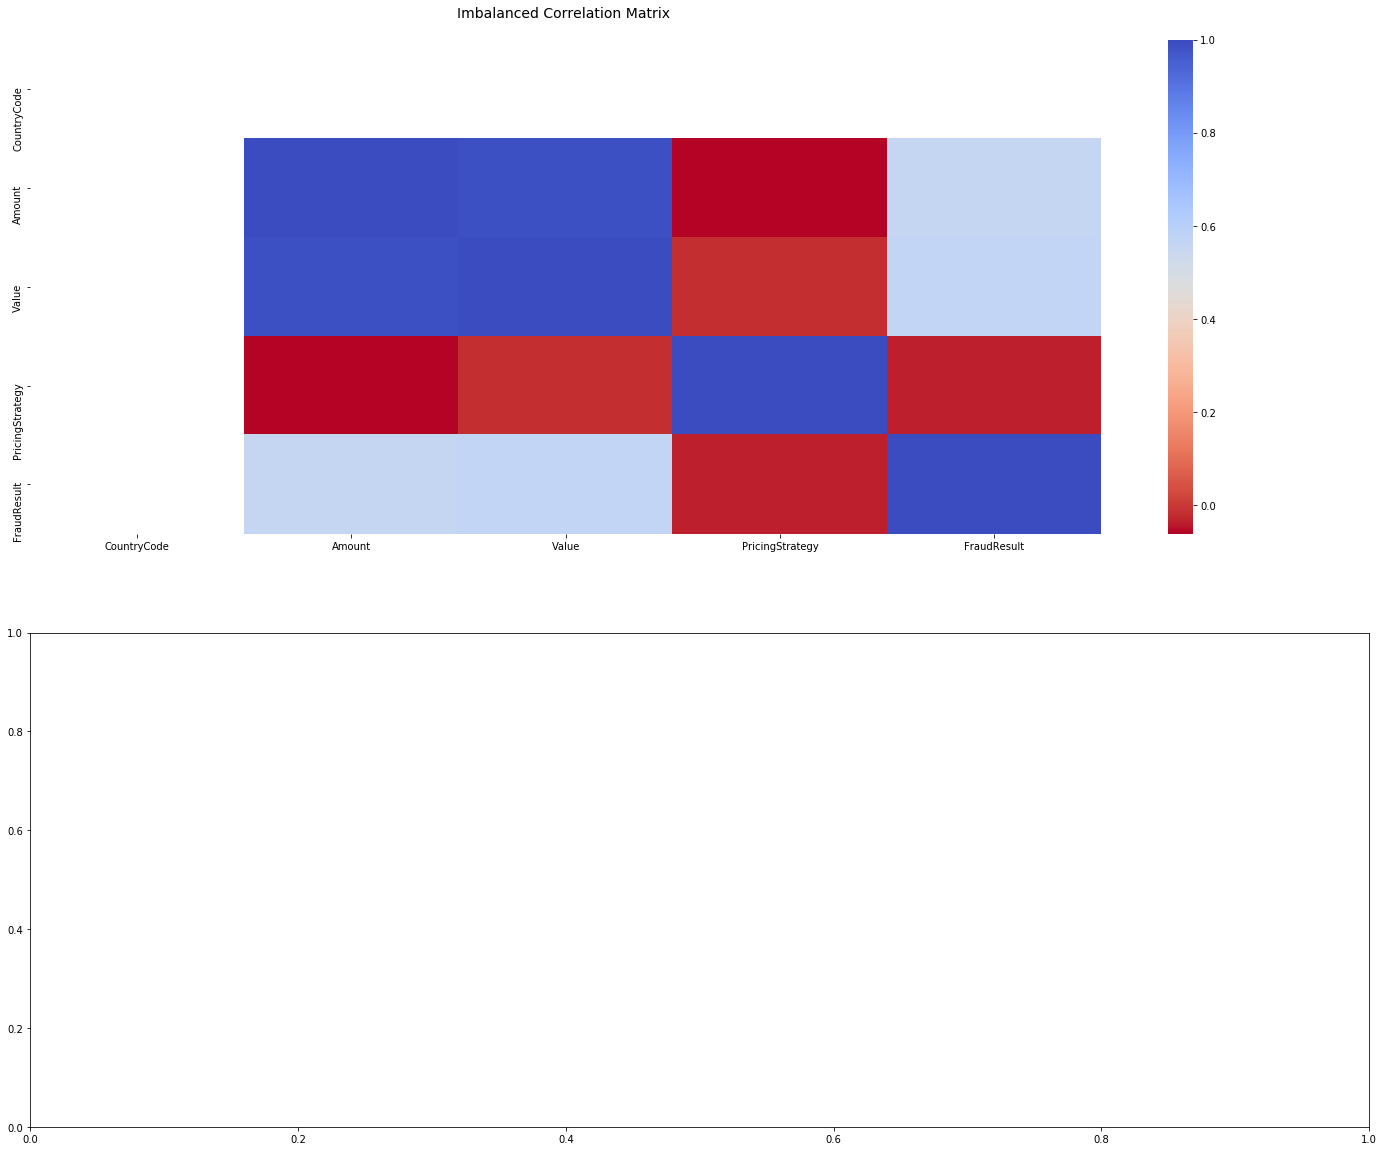

In [71]:
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(24,20))
# subsample DataFrame
corr = df.corr()
sns.heatmap(corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax1)
ax1.set_title("Imbalanced Correlation Matrix \n ", fontsize=14)

In [72]:
data_features_encoded=MultiColumnLabelEncoder(columns = ['ProviderId', 'ProductId',
                                                         'ProductCategory','ChannelId', 'PricingStrategy']).fit_transform(data_features)
data_features_encoded.head()



,ProviderId,ProductId,ProductCategory,ChannelId,PricingStrategy,Amount
0,5,1,0,2,2,1000.0
1,3,19,2,1,2,-20.0
2,5,0,0,2,2,500.0
3,0,11,8,2,2,20000.0
4,3,19,2,1,2,-644.0


In [73]:
d = defaultdict(LabelEncoder)
df=data_features[['ProviderId', 'ProductCategory']]

# Encoding the variable
fit = df.apply(lambda x: d[x.name].fit_transform(x))

# Inverse the encoded
#fit.apply(lambda x: d[x.name].inverse_transform(x))

# Using the dictionary to label future data
#df.apply(lambda x: d[x.name].transform(x))
data_features_encoded=pd.merge(fit, data_features[['Amount']], right_index=True, left_index=True)
data_features_encoded.head()

,ProviderId,ProductCategory,Amount
0,5,0,1000.0
1,3,2,-20.0
2,5,0,500.0
3,0,8,20000.0
4,3,2,-644.0


In [74]:
new_df=pd.merge(data_features_encoded, data_target, right_index=True, left_index=True)
new_df.head()

,ProviderId,ProductCategory,Amount,FraudResult
0,5,0,1000.0,0
1,3,2,-20.0,0
2,5,0,500.0,0
3,0,8,20000.0,0
4,3,2,-644.0,0


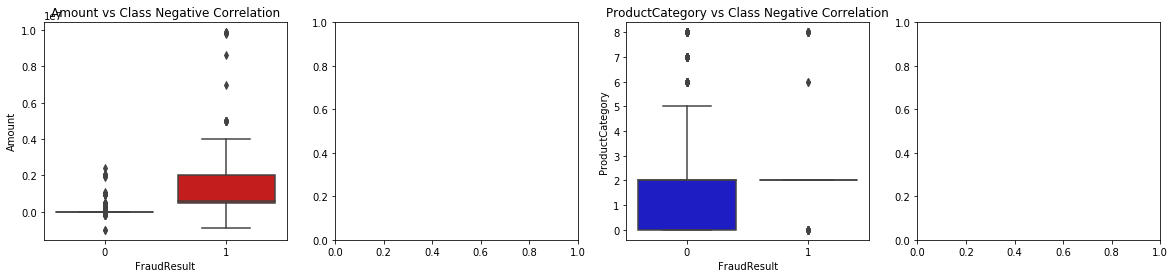

In [75]:

f, axes = plt.subplots(ncols=4, figsize=(20,4))
colors = ["#0101DF", "#DF0101"]
# Negative Correlations with our Class (The lower our feature value the more likely it will be a fraud transaction)
sns.boxplot(x='FraudResult', y='Amount', data=new_df, palette=colors, ax=axes[0])
axes[0].set_title('Amount vs Class Negative Correlation')

#sns.boxplot(x='FraudResult', y='ChannelId', data=new_df, palette=colors, ax=axes[1])
#axes[1].set_title('ChannelId vs Class Negative Correlation')


sns.boxplot(x='FraudResult', y='ProductCategory', data=new_df, palette=colors, ax=axes[2])
axes[2].set_title('ProductCategory vs Class Negative Correlation')


#sns.boxplot(x='FraudResult', y='ProductId', data=new_df, palette=colors, ax=axes[3])
#axes[3].set_title('ProductId vs Class Negative Correlation')

plt.show()

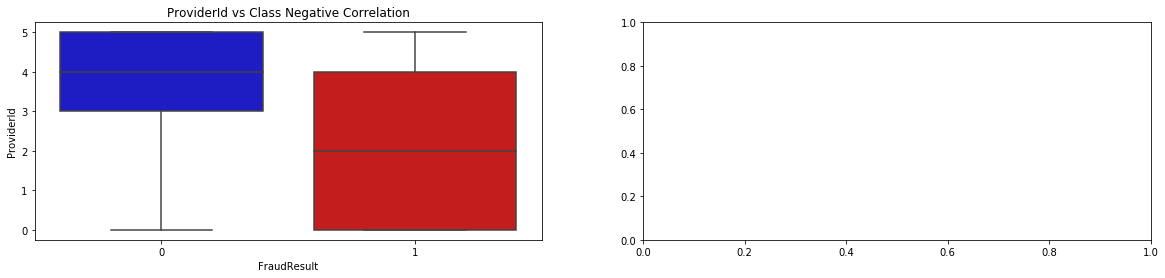

In [76]:

f, axes = plt.subplots(ncols=2, figsize=(20,4))
colors = ["#0101DF", "#DF0101"]
# Negative Correlations with our Class (The lower our feature value the more likely it will be a fraud transaction)
sns.boxplot(x='FraudResult', y='ProviderId', data=new_df, palette=colors, ax=axes[0])
axes[0].set_title('ProviderId vs Class Negative Correlation')

#sns.boxplot(x='FraudResult', y= 'PricingStrategy', data=new_df, palette=colors, ax=axes[1])
#axes[1].set_title( 'PricingStrategy vs Class Negative Correlation')


plt.show()

In [77]:
new_df.head()

,ProviderId,ProductCategory,Amount,FraudResult
0,5,0,1000.0,0
1,3,2,-20.0,0
2,5,0,500.0,0
3,0,8,20000.0,0
4,3,2,-644.0,0


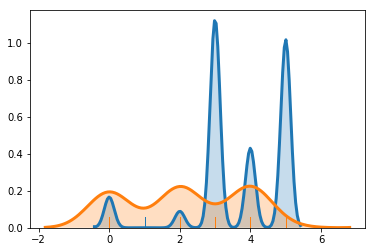

In [79]:
target_1 = new_df.loc[new_df['FraudResult'] == 0]
target_2 = new_df.loc[new_df['FraudResult'] == 1]

sns.distplot(target_1[['ProviderId']], hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 3}, rug=True)
sns.distplot(target_2[['ProviderId']], hist=False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 3}, rug=True)


In [80]:
#target_1 = new_df.loc[new_df['ProductId'] == 0]
#target_2 = new_df.loc[new_df['ProductId'] == 1]

#sns.distplot(target_1[['ProviderId']], hist = False, kde = True,
 #                kde_kws = {'shade': True, 'linewidth': 3}, rug=True)
#sns.distplot(target_2[['ProviderId']], hist=False, kde = True,
 #                kde_kws = {'shade': True, 'linewidth': 3}, rug=True)

C:\Users\Matthew.Fry\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\Matthew.Fry\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


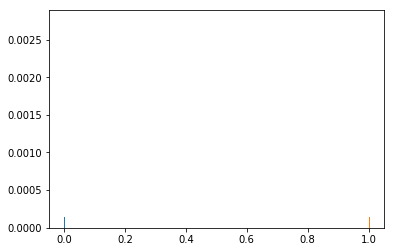

In [81]:
target_1 = new_df.loc[new_df['ProductCategory'] == 0]
target_2 = new_df.loc[new_df['ProductCategory'] == 1]

sns.distplot(target_1[['ProductCategory']], hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 3}, rug=True)
sns.distplot(target_2[['ProductCategory']], hist=False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 3}, rug=True)

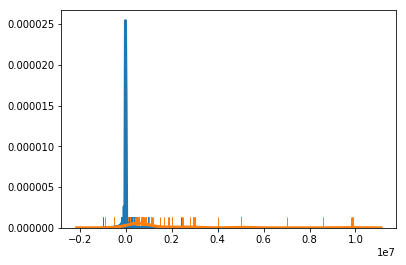

In [83]:
target_1 = new_df.loc[new_df['FraudResult'] == 0]
target_2 = new_df.loc[new_df['FraudResult'] == 1]

sns.distplot(target_1[['Amount']], hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 3}, rug=True)
sns.distplot(target_2[['Amount']], hist=False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 3}, rug=True)

In [85]:
nfeature_names = ['Amount','ProviderId', 'ProductCategory']#'ProviderId', 'ProductId','ProductCategory','ChannelId',
data_features_encoded=data_features_encoded[nfeature_names]
data_features_encoded.head()

,Amount,ProviderId,ProductCategory
0,1000.0,5,0
1,-20.0,3,2
2,500.0,5,0
3,20000.0,0,8
4,-644.0,3,2


In [86]:
from sklearn.model_selection import train_test_split
np.random.seed(123)
X_train, X_test, y_train, y_test = train_test_split(data_features_encoded,data_target, train_size=0.90, test_size=0.10, random_state=1)
y_train=y_train.values.ravel()

In [87]:
##Target Encoding which didn't do much for me!
#columns=['ProviderId', 'ProductId']
#targ_enc = TargetEncoder(cols=columns, smoothing=8, min_samples_leaf=5).fit(X_train, y_train)
#X_train = targ_enc.transform(X_train.reset_index(drop=True))
#X_test = targ_enc.transform(X_test.reset_index(drop=True))
#_train.head()

In [88]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
cmat, pred = RunModel2(lr, X_train, y_train, X_test, y_test)
PrintStats(cmat, y_test, pred)

[[9542    4]
 [  18    3]]
Accuracy: 99.77%
Cohen Kappa: 0.213
Sensitivity/Recall for Model : 0.14
F1 Score for Model : 0.21


In [89]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators = 200, n_jobs =4)
cmat, pred = RunModel2(rf, X_train, y_train, X_test, y_test)
PrintStats(cmat, y_test, pred)

[[9544    2]
 [   4   17]]
Accuracy: 99.94%
Cohen Kappa: 0.85
Sensitivity/Recall for Model : 0.81
F1 Score for Model : 0.85


In [90]:
from sklearn.ensemble import GradientBoostingClassifier
gbc = GradientBoostingClassifier(n_estimators=200,learning_rate=0.02,max_depth=5, random_state=0,
                                 min_samples_leaf= 3, min_samples_split= 4,
                                  max_features = 'sqrt' ,subsample = 0.8).fit(X_train, y_train)
cmat, pred = RunModel2(gbc, X_train, y_train, X_test, y_test)
PrintStats(cmat, y_test, pred)

[[9544    2]
 [   5   16]]
Accuracy: 99.93%
Cohen Kappa: 0.82
Sensitivity/Recall for Model : 0.76
F1 Score for Model : 0.82


In [91]:
X_train, X_test, y_train, y_test = train_test_split(data_features_encoded,data_target, train_size=0.90, test_size=0.10, random_state=1)
sm = SMOTE(random_state=12, ratio =0.1)
X_train, y_train = sm.fit_sample(X_train, y_train.values.ravel())
y_train

array([0, 0, 0, ..., 1, 1, 1], dtype=int64)

In [92]:
from sklearn.ensemble import GradientBoostingClassifier
gbc2 = GradientBoostingClassifier(n_estimators=200,learning_rate=0.01,max_depth=5, random_state=0,
                                 min_samples_leaf= 3, min_samples_split= 4,
                                  max_features = 'sqrt' ,subsample = 0.8).fit(X_train, y_train)
cmat, pred = RunModel2(gbc2, X_train, y_train, X_test, y_test)
PrintStats(cmat, y_test, pred)

[[9529   17]
 [   1   20]]
Accuracy: 99.81%
Cohen Kappa: 0.689
Sensitivity/Recall for Model : 0.95
F1 Score for Model : 0.69


In [93]:
data_features_encoded.head()

,Amount,ProviderId,ProductCategory
0,1000.0,5,0
1,-20.0,3,2
2,500.0,5,0
3,20000.0,0,8
4,-644.0,3,2


In [94]:

# we should scale the columns that are left to scale (Amount and Time)
from sklearn.preprocessing import StandardScaler, RobustScaler

# RobustScaler is less prone to outliers.

rob_scaler = RobustScaler()
data_features_scaled=data_features_encoded
data_features_scaled['scaled_amount'] = rob_scaler.fit_transform(data_features_scaled['Amount'].values.reshape(-1,1))
data_features_scaled.drop(['Amount'], axis=1, inplace=True)


C:\Users\Matthew.Fry\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [95]:
from sklearn.model_selection import train_test_split
np.random.seed(123)
X_train1, X_test1, y_train1, y_test1 = train_test_split(data_features_scaled,data_target, train_size=0.90, test_size=0.10, random_state=1)


In [96]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators = 200, n_jobs =6)
cmat, pred = RunModel(rf, X_train1, y_train1, X_test1, y_test1)
PrintStats(cmat, y_test, pred)

[[9544    2]
 [   4   17]]
Accuracy: 99.94%
Cohen Kappa: 0.85
Sensitivity/Recall for Model : 0.81
F1 Score for Model : 0.85


# Now to appply the model to the data for submission¶

In [97]:
trained_model=gbc.fit(X_train, y_train)
df_test = pd.read_csv('test.csv')
X_sub = df_test[['ProviderId','ProductCategory']]#,'ChannelId', 'PricingStrategy'

#X_sub['scaled_amount'] = rob_scaler.fit_transform(X_sub['Amount'].values.reshape(-1,1))
#X_sub.drop(['Amount'], axis=1, inplace=True)

#X_sub = MultiColumnLabelEncoder(columns = ['ProviderId', 'ProductId','ProductCategory','ChannelId']).transform(X_sub)
# Using the dictionary to label future data
X_sub.apply(lambda x: d[x.name].transform(x))
##https://stackoverflow.com/questions/24458645/label-encoding-across-multiple-columns-in-scikit-learn/30267328#30267328

ValueError: ("y contains previously unseen labels: 'retail'", 'occurred at index ProductCategory')

In [ ]:
X_sub=pd.merge(X_sub, df_test[['Amount']], right_index=True, left_index=True)
X_sub=X_sub[nfeatures]
result=trained_model.predict(X_sub)
print(len(X_sub.index))

In [ ]:
Submission=pd.DataFrame(result)
Submission['TransactionId']=df_test ['TransactionId']
Submission = Submission.set_index('TransactionId')
Submission.columns=["FraudResult"]
#Submission=Submission.assign(id=y_sub)
Submission.to_csv('submission.csv')
Submission.head()

In [ ]:
print(Submission.FraudResult.value_counts().rename(index = class_names))

In [ ]:
X_sub.tail()